In [16]:
from IPython.display import HTML
from sklearn.neighbors import NearestNeighbors

In [2]:
import pandas as pd
import networkx as nx
import community
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np
from collections import defaultdict
from sklearn.neighbors import BallTree
import gc
%matplotlib inline

columns = ["pubId", "is_hourly", "seqId", "on_homepage", "canonicalUrl",
                   "firstScrape", "lang_iso", "lang_reliability", "title", "text"]

def read_article_df(file):
    articles_dt = file.read().split('\n')[:-1]
    pubId, canonicalUrl,firstScrape,title,text,lang_reliability = [],[],[],[],[],[]
    lang_iso = []
    for article in articles_dt:    
        row = article.split('\t')
        pubId.append(row[0])
        canonicalUrl.append(row[4])
        firstScrape.append(row[5])
        lang_iso.append(row[6])
        lang_reliability.append(row[7])
        title.append(row[8])
        text.append(row[9])

    articles_df = pd.DataFrame()
    articles_df['pubId'] = pubId
    articles_df['canonicalUrl'] = canonicalUrl
    articles_df['firstScrape'] = firstScrape
    articles_df['title'] = title
    articles_df['text'] = text
    articles_df['lang_reliability'] = lang_reliability
    articles_df['lang_iso'] = lang_iso
    return articles_df

In [3]:
emb_df = pd.read_csv('../data/embedding/Glove_embedding_output.csv',index_col=0)

In [4]:
article_df = read_article_df(open('../data/raw/2018_07_19_04_59_08/articles.txt', encoding='utf-8'))
article_df = article_df[article_df.lang_reliability == '1'].reset_index(drop=True)

In [5]:
article_df['title'] = article_df.title.apply(lambda s: s.strip())
article_df['text'] = article_df.text.apply(lambda s: s.strip())
article_df['title_len'] = article_df.title.apply(len)
article_df['text_len'] = article_df.text.apply(len)

In [6]:
clean_df = article_df[article_df.title_len > 0]
clean_df = clean_df[clean_df.text_len > 100]
clean_df = clean_df[clean_df.lang_iso == 'en']
clean_df.shape

(176664, 9)

In [7]:
label1 = pd.read_csv('../data/raw/labels/cave_rescue/population.txt', header=None)
label1.columns = ['canonicalUrl']
label1['label'] = 1

label2 = pd.read_csv('../data/raw/labels/duckboat/population.txt', header=None)
label2.columns = ['canonicalUrl']
label2['label'] = 2

label3 = pd.read_csv('../data/raw/labels/helsinki_summit/population.txt', header=None)
label3.columns = ['canonicalUrl']
label3['label'] = 3

In [8]:
label_df = pd.concat([label1, label2, label3])
label_df

,canonicalUrl,label
0,denverpost.com/2018/07/20/greeley-police-lip-s...,1
1,bbc.com/news/av/world-asia-44875089/thai-cave-...,1
2,news.google.com/stories/caaqzggkimbdqkltuwpvsm...,1
3,chron.com/news/crime/article/young-nubians-rev...,1
4,cnbc.com/2018/07/20/at-least-13-die-when-duck-...,1
...,...,...
1920,beforeitsnews.com/opinion-conservative/2018/07...,3
1921,washingtonpost.com/news/powerpost/paloma/the-h...,3
1922,feeds.nydailynews.com/~r/nydnrss/news/national...,3
1923,news.google.com/stories/caaqoqgkijndqkltsurvsm...,3


In [9]:
clean_df = clean_df.merge(label_df, on='canonicalUrl', how='left')

In [10]:
clean_df.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
0,290,zerohedge.com/news/2018-07-19/i-told-you-so-tr...,7/19/2018 10:41:26 AM -04:00,"""I Told You So"": Trump Hits Out At EU After $5...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,79,2134,NaN
1,290,zerohedge.com/news/2018-07-19/trump-invites-pu...,7/19/2018 5:03:01 PM -04:00,Trump Invites Putin To Ahead Of Midterms | Ze...,"by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,54,4555,NaN
2,290,zerohedge.com/news/2018-07-19/gallup-shows-how...,7/19/2018 8:26:52 AM -04:00,Gallup Shows How Much Americans Really Care Ab...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,76,3133,NaN
3,290,zerohedge.com/news/2018-07-19/california-supre...,7/19/2018 8:26:52 AM -04:00,California Supreme Court Blocks Proposal To Sp...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,85,3567,NaN
4,290,zerohedge.com/news/2018-07-19/why-are-thousand...,7/19/2018 4:28:52 PM -04:00,"Why Are ""Thousands"" of Teslas Sitting In a Fie...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,62,3584,NaN


In [11]:
article_with_label = clean_df[~clean_df.label.isna()]
article_without_label = clean_df[clean_df.label.isna()]
article_with_label.shape, article_without_label.shape

((624, 10), (176045, 10))

Sample and include all the labeled article

In [12]:
sample_df = pd.concat([article_with_label, article_without_label.sample(10000)])

In [13]:
sample_emb_df = emb_df.loc[sample_df.index]

In [ ]:
tree = BallTree(sample_emb_df)
neighbors = tree.query_radius(sample_emb_df, 0.2)
neighbors_count = [len(n) for n in neighbors]

In [20]:
nn = NearestNeighbors(n_neighbors=10, metric='cosine')
nn.fit(sample_emb_df)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [21]:
admat = nn.kneighbors_graph()

In [24]:
admat

<10624x10624 sparse matrix of type '<class 'numpy.float64'>'
	with 106240 stored elements in Compressed Sparse Row format>

In [ ]:
G = nx.from_scipy_sparse_matrix(admat)

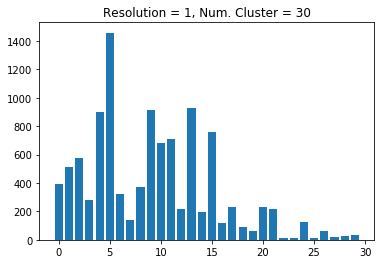

In [29]:
partitions = []
resolutions = [1] #, .99, .999, .9995, .9999]
for resolution in resolutions:
    partition = community.best_partition(G, resolution=resolution)
    partitions.append(partition)
    num_cluster = max([v for k,v in partition.items()]) + 1
    clusters = defaultdict(list)
    for k, v in partition.items():
        clusters[v].append(k)

    cluster_sizes = []
    for i, cluster in clusters.items():
        cluster_sizes.append(len(cluster))
    plt.bar(list(range(len(cluster_sizes))), cluster_sizes)
    plt.title(f'Resolution = {resolution}, Num. Cluster = {num_cluster}')
    plt.show()

In [30]:
np.argmax(cluster_sizes), np.max(cluster_sizes), np.median(cluster_sizes)

(5, 1458, 224.0)

In [31]:
def plot_cluster_sizes(cluster):
    cluster_sizes = []
    for i, c in cluster.items():
        cluster_sizes.append(len(c))
    plt.title(f'Num cluster = {len(cluster.keys())}')
    plt.hist(cluster_sizes)
    plt.show()
    
def prune_cluster(cluster: dict, threshold) -> dict:
    pc = {}
    for key, value in clusters.items():
        if len(value) > threshold:
            pc[key] = value
    return pc

In [32]:
pc = prune_cluster(cluster, 5)

In [33]:
article_cluster = list(map(lambda d: clean_df.iloc[d[1]], pc.items()))
len(article_cluster)

30

In [34]:
len(article_cluster[0].title.tolist())

393

In [35]:
pc.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [54]:
n = len(pc.keys())
sample_cluster = np.random.randint(n)
print('-'*50, 'title', '-'*50)
print('\n'.join(article_cluster[sample_cluster].title.tolist()))
print('-'*50, 'text', '-'*50)
print('\n'.join(list(map(lambda x: x[:100], article_cluster[sample_cluster].text.tolist()))))

-------------------------------------------------- title --------------------------------------------------
American Cold War Experts: "The Real Threat Is Russophobia
The Establishment Strikes Back | Zero Hedge
Russian Warship "Carrying $133 Billion In Gold" Discovered Off South Korea | Zero Hedge
Central Banks Are Using The Trade War To Hide Their Direct Influence On Stocks | Zero Hedge
What does your child know about getting lost?
Tony Fair's trust in Husker coaches helped Nebraska land the massive juco nose tackle
Video: 3 Secrets To Using MoviePass
Olivia Munn Receives the IMDb STARmeter Award Aboard the #IMDboat at San Diego Comic-Con
Even fine cast can't make 'The Seagull' soar
Sweeney induces double play, leads AZL Cubs 2 to 4-3 win over AZL Reds
Jalen Stephens makes name for himself | Meyersdale | dailyamerican.com
We all need a Waldon Pond experience
Helicopter mishap turns Army medical drill into real deal | World/Nation | dailyamerican.com
Nickelodeon’s Kids’ Choice Sports 2

## Top clusters

In [37]:
cluster_sizes = np.array(list(map(len, article_cluster)))

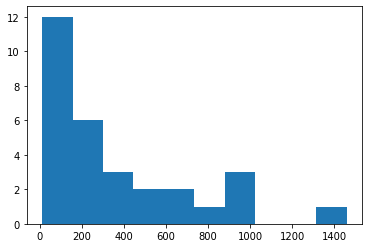

In [38]:
plt.hist(cluster_sizes);

In [39]:
index_by_size = list(reversed(np.argsort(cluster_sizes)))
cluster_sizes[index_by_size]

array([1458,  928,  916,  902,  762,  708,  684,  574,  510,  393,  375,
        320,  279,  234,  230,  218,  217,  199,  138,  125,  119,   88,
         65,   60,   33,   25,   22,   15,   15,   12])

In [40]:
top_cluster = article_cluster[index_by_size[0]]
top_cluster.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
10,290,zerohedge.com/news/2018-07-19/portland-police-...,7/19/2018 5:36:17 PM -04:00,"Portland Police Union President: ""Our City Has...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,104,6999,NaN
16,290,zerohedge.com/news/2018-07-19/china-shocked-be...,7/19/2018 8:26:52 AM -04:00,"China ""Shocked Beyond Imagination"" At Larry Ku...","by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,85,3287,NaN
20,290,zerohedge.com/news/2018-07-19/us-diplomacy,7/20/2018 9:16:59 PM -04:00,"US ""Diplomacy""","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,14,7948,NaN
40,290,zerohedge.com/news/2018-07-19/day-stretegic-am...,7/19/2018 7:17:26 PM -04:00,"The Day ""Strategic Ambiguity"" Died | Zero Hedge","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,47,6962,NaN
64,290,zerohedge.com/news/2018-07-19/how-alexandria-o...,7/19/2018 10:41:26 AM -04:00,How Alexandria Ocasio-Cortez Misunderstands Am...,"by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,73,7350,NaN


In [41]:
top_cluster.label.unique()

array([nan])

In [48]:
for i, a in enumerate(article_cluster):
    a['assignment'] = i

C:\Users\harinsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
articles = pd.concat(article_cluster)

In [53]:
articles.dropna()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label,assignment
29,290,zerohedge.com/news/2018-07-19/white-house-aske...,7/20/2018 1:35:15 AM -04:00,"Asked 8 Times For Trump-Rouhani Meeting, Iran ...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,63,2701,3.0,2
58,290,zerohedge.com/news/2018-07-19/plague-military-...,7/19/2018 11:51:38 PM -04:00,The Plague Of Military Keynesianism And The Ob...,"by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,59,8615,3.0,2
22,290,zerohedge.com/news/2018-07-19/wells-fargo-has-...,7/19/2018 11:53:37 AM -04:00,Wells Fargo Caught In Yet Another Scandal | Ze...,"by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,54,5018,3.0,4
11,290,zerohedge.com/news/2018-07-19/la-liberals-stag...,7/19/2018 7:50:19 PM -04:00,"LA Liberals Stage ""Emergency Protest"" At Koshe...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,75,3317,3.0,6
52,290,zerohedge.com/news/2018-07-19/maxine-waters-fe...,7/19/2018 1:03:04 PM -04:00,"Maxine Waters Fears ""Armed Protests"" As Oath K...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,88,3952,1.0,6
61,290,zerohedge.com/news/2018-07-19/skripal-poisonin...,7/19/2018 11:16:00 AM -04:00,"Skripal Poisoning Suspects 'Identified': ""[We'...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,71,3105,3.0,10
33,290,zerohedge.com/news/2018-07-18/wheres-panic-why...,7/19/2018 8:26:52 AM -04:00,"""Where’s The Panic"": Why Trade War Hedges Aren...","by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,69,3265,3.0,13
62,290,zerohedge.com/news/2018-07-19/fbi-chief-threat...,7/19/2018 8:26:52 AM -04:00,FBI Chief Threatens To Quit If Trump Invites R...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,78,2858,3.0,17
